# Load libraries

In [1]:
#Note: This notebook was run in the conda environment named "Jacob_Env2" (provided on GitHub)
#Note: This notebook builds on 2023_Notebook-Fibroblasts_Part1 which needs to be run prior to running this notebook

In [2]:
#You are currently looking at the notebook processing/plotting fibroblasts only
cell_type = 'Fib'

In [3]:
#Load the required packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import pandas as pd
import numpy as np
import sys
import seaborn as sbn
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import bbknn
from IPython.display import clear_output
import csv

import cellrank as cr
from cellrank.tl.estimators import GPCCA
from cellrank.tl.kernels import PseudotimeKernel

In [4]:
#Set paths
path = '/mnt/c/Users/User/Jacob-Et-Al'

In [5]:
#Load gene list required for cell cycle scoring
cell_cycle_genes_path = os.path.join(path,'Notebook-Input','regev_lab_cell_cycle_genes.txt')
cell_cycle_genes = [x.strip().title() for x in open(cell_cycle_genes_path)]

# Separate dataset for S-phase or G2M-phase associated genes
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [6]:
scv.logging.print_version()
cr.logging.print_versions()

Running scvelo 0.2.4 (python 3.8.10) on 2023-04-06 15:58.
cellrank==1.5.1 scanpy==1.8.2 anndata==0.7.6 numpy==1.21.2 numba==0.55.0 scipy==1.7.1 pandas==1.3.2 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [7]:
#Define function that can remove axis elements from subplots
#axes can be either an individual subplot, a list of individual subplots or mix of multiple subplots in a nested list.
def clean_axis(axes, remove_borders = True, remove_ticks = True, remove_axis_labels = True):
    axes = flatten_list(axes)
    print(axes)
    for ax in axes:
        if remove_borders:
            for loc in ['left','right','top','bottom']:
                ax.spines[loc].set_visible(False)
        if remove_ticks:
            for side in ['x','y']:
                ax.tick_params(
                    axis=side,  # changes apply to the x-axis
                    which='both',  # both major and minor ticks are affected
                    bottom=False,  # ticks along the bottom edge are off
                    top=False,  # ticks along the top edge are off
                    left=False,
                    labelbottom=False,
                    labelleft=False,
                    labeltop = False)
        if remove_axis_labels:
            ax.set_ylabel('')
            ax.set_xlabel('')

#Define function to return the correct axis 
def get_ax(axes, ix, ncols):
    if len(axes.shape) > 1:
        return axes[ix // ncols, ix % ncols]
    else:
        return axes[ix]
    
#Define function to make a flat iteratable list out of a single element or a nested list
def flatten_list(lst):
    if type(lst)==np.ndarray:
        lst = lst.tolist()    
    if type(lst)!=list:
        lst = [lst]
    elif len(lst)==1:
        lst = lst[0]
    elif not all([type(l)==list for l in lst]):
        lst = [[l] if type(l)!=list else l for l in lst]
        lst = [l for sublist in lst for l in sublist]
    else:
        lst = [l for sublist in lst for l in sublist]
    return lst

#Define function to generate a plot with multiple subplots
def initialize_subplots(groups_to_plot, ncols = 3, figsize_multiplier = (7,5), gridspec_kw = None, figsize = None, print_help = True, **fig_kw):
    if type(groups_to_plot)==list:
        total = len(groups_to_plot)
    else:
        total = groups_to_plot
    nrows = int(np.ceil(total/ncols))
    if not figsize:
        figsize = (figsize_multiplier[0]*ncols, figsize_multiplier[1]*nrows)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize, gridspec_kw = gridspec_kw, **fig_kw)
    if print_help:
        if nrows>1 and ncols>1:
            print('ax = axes[ix // ncols, ix % ncols]')
        else:
            print('ax = axes[ix]')
    return fig, axes

# Load and subset adata object from 2023_Notebook-Fibroblasts_Part1

In [8]:
#Load adata object with preveiously calculated velocity
adata_velo = sc.read_h5ad(os.path.join(path, 'Notebook-Output', 'Adata-object_{}-subset-velocity-analysis.h5'.format(cell_type)))

In [9]:
#Assign colors to fibroblast subclusters
cmap = {'FIB Origin1': '#666565',
        'FIB Origin2': '#336666',
        'FIB Origin3': '#070707',
        'FIB Origin4': '#B2BCAF',
        'FIB Origin5': '#8FA3CC',
        'FIB Origin6': '#333B5B',
        'FIB Upper1': '#FABAA2',
        'FIB Upper2': '#F86B51',
        'FIB Upper3': '#C12489',
        'FIB Upper4': '#CE73E0',
        'FIB DC': '#634493',
        'FIB Inter1': '#32B6EA',
        'FIB Inter2': '#1978E0',
        'FIB Inter3': '#253EF2',
        'FIB Lower': '#FCC25A',
        'FIB Deep1': '#9D7866',
        'FIB Deep2': '#DD8129',
        'FIB Deep3': '#7D3B12',
        'CHOND': '#77C279',
        'FIB Muscle1': '#02441C',
        'FIB Muscle2': '#149914'}

adata_velo.uns['leiden_named_colors'] = [cmap[x] for x in adata_velo.obs['leiden_named'].cat.categories]

In [10]:
#Subset adata object (which already excludes chondrocytes) to all fibroblasts except FIB Deep clusters
#We are interested in understanding which cell clusters originate from FIB Origin subclusters and if there already is a bias of certain FIB Origin subclusters giving preferential rise to certain fibroblast subclusters from E13.5 and E14.5
#Thus, we exclude FIB Deep clusters which co-exist with FIB Origin clusters at E12.5 and most likely do not originate from FIB Origin clusters
adata_velo_nodeep = adata_velo[~adata_velo.obs['leiden_named'].isin(['FIB Deep1','FIB Deep2','FIB Deep3'])].copy()

<AxesSubplot:>

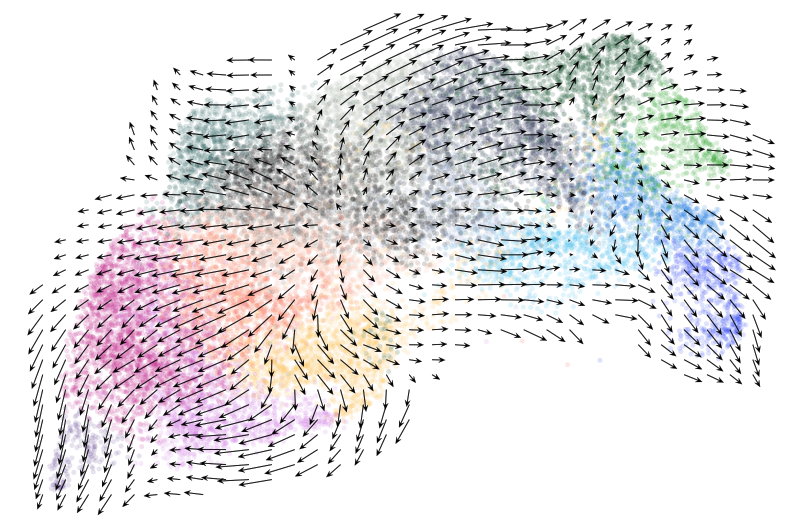

In [11]:
#Display precalculated velocity on fibroblast subset (excl. chondrocytes and FIB deep clusters)
mult = 2
fig, ax = plt.subplots(figsize = (7*mult, 4.7*mult))
scv.pl.velocity_embedding_grid(adata_velo_nodeep, basis='umap', legend_fontsize=12, title='', smooth=1, min_mass=1, s=100,alpha=0.15, color = ['leiden_named'], ax = ax, show = False, frameon = False,arrow_color='black',arrow_size=1.4,arrow_length=5, density = 0.65)

# Pseudotime analysis

## Pseudotime based on diffusion map (Scanpy)

In [12]:
#Generate diffusion map of fibroblasts (excl. chondrocytes and FIB Deep clusters)
sc.tl.diffmap(adata_velo_nodeep)

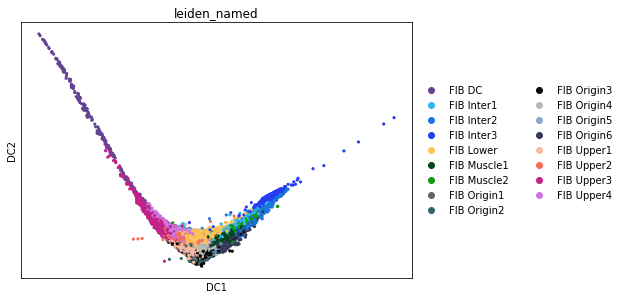

In [13]:
#display diffusion map
mult = 1
fig, ax = plt.subplots(figsize = (7*mult, 4.7*mult))
sc.pl.diffmap(adata_velo_nodeep, color = 'leiden_named', ax = ax, s = 40)

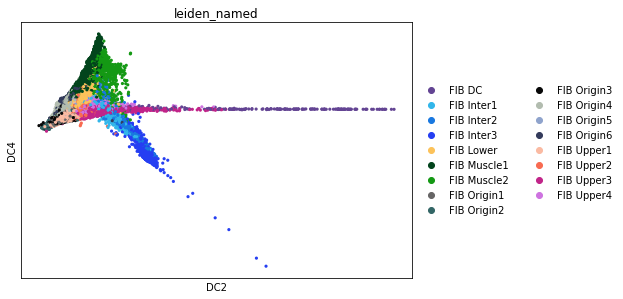

In [14]:
#After looking at diffusion maps (combinations of different diffusion components), the combination of DC2 and DC4 was found to show a nice separation of the predicted enpoints (FIB Upper, FIB Inter, FIB Muscle)
mult = 1
fig, ax = plt.subplots(figsize = (7*mult, 4.7*mult))
sc.pl.diffmap(adata_velo_nodeep, color = 'leiden_named', ax = ax, s = 40, components = [2,4])

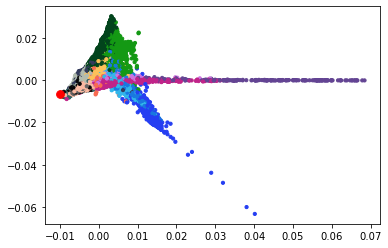

In [15]:
#Define root cell i.e. set root cell to be the left-most cell in the scatter plot (corresponding to diffusion plot of DC2 and DC4)
x,y = zip(*adata_velo_nodeep.obsm['X_diffmap'][:, 2:5:2]) #Indexing to get components 2 and 4
cmap = {cl: color for cl, color in zip(*[adata_velo_nodeep.obs['leiden_named'].cat.categories, adata_velo_nodeep.uns['leiden_named_colors']])}
plt.scatter(x, y, c = [cmap[x] for x in adata_velo_nodeep.obs['leiden_named'].values], s = 10)
iroot = np.argmin(x)
plt.scatter(x[iroot], y[iroot], color = 'r', s = 60)
adata_velo_nodeep.uns['iroot'] = iroot

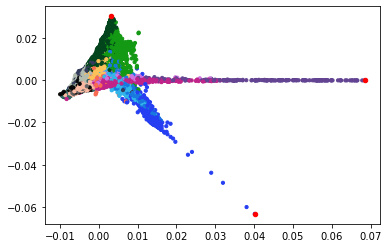

In [16]:
#Define endpoints i.e. the most distant point of the different extremities
x, y = zip(*adata_velo_nodeep.obsm['X_diffmap'][:, 2:5:2]) #ndexing to get components 2 and 4
x, y = np.array(x), np.array(y)
cmap = {cl: color for cl, color in zip(*[adata_velo_nodeep.obs['leiden_named'].cat.categories, adata_velo_nodeep.uns['leiden_named_colors']])}
plt.scatter(x, y, c = [cmap[x] for x in adata_velo_nodeep.obs['leiden_named'].values], s = 10)
end_points = [np.argmax(y), np.argmin(y), np.argmax(x)]
plt.scatter(x[end_points], y[end_points], color = 'r', s = 20)

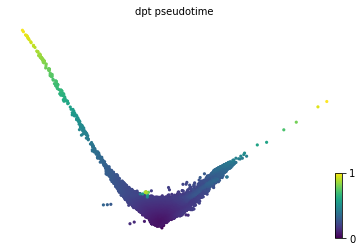

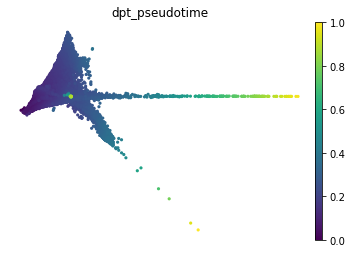

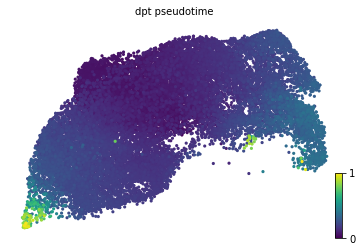

In [17]:
#Calculate and display diffusion pseudotime (takes the root cell as the starting point of pseudotime)
#Number of branchings have to be specified. Having 1 or 2 branchings gives the same result. 3 branchings results in error.
sc.tl.dpt(adata_velo_nodeep, n_branchings=1)
scv.pl.scatter(adata_velo_nodeep, basis = 'diffmap', color='dpt_pseudotime', cmap='viridis', s = 40)
sc.pl.diffmap(adata_velo_nodeep, color = 'dpt_pseudotime', cmap = 'viridis', s = 40, components = [2,4], frameon = False)
scv.pl.scatter(adata_velo_nodeep, basis = 'umap', color='dpt_pseudotime', cmap='viridis', s = 40)

## Pseudotime based on velocity (Scvelo)

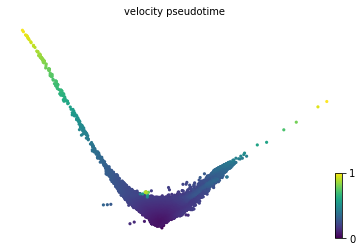

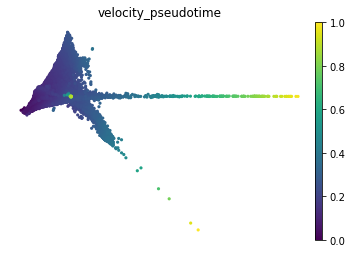

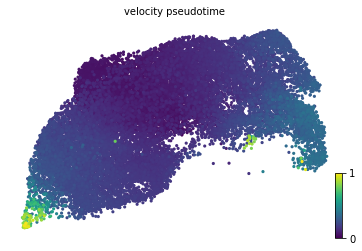

In [18]:
#Calculate and display velocity pseudotime (takes the root and end cells defined above into account)
#Note: gives very similar results to pseudotime based on diffusion maps
scv.tl.velocity_pseudotime(adata_velo_nodeep, root_key=iroot, end_key = end_points, use_velocity_graph=False)
scv.pl.scatter(adata_velo_nodeep, basis = 'diffmap', color='velocity_pseudotime', cmap='viridis', s = 40)
sc.pl.diffmap(adata_velo_nodeep, color = 'velocity_pseudotime', cmap = 'viridis', s = 40, components = [2,4], frameon = False)
scv.pl.scatter(adata_velo_nodeep, basis = 'umap', color='velocity_pseudotime', cmap='viridis', s = 40)

## Merge endpoint subclusters

In [19]:
combined_dict = {
    'FIB DC': 'FIB DC',
    'FIB Muscle1': 'FIB Muscle',
    'FIB Muscle2': 'FIB Muscle',
    'FIB Origin1': 'FIB Origin1',
    'FIB Origin2': 'FIB Origin2',
    'FIB Origin3': 'FIB Origin3',
    'FIB Origin4': 'FIB Origin4',
    'FIB Origin5': 'FIB Origin5',
    'FIB Origin6': 'FIB Origin6',
    'FIB Lower': 'FIB Lower',
    'FIB Inter1': 'FIB Inter',
    'FIB Inter2': 'FIB Inter',
    'FIB Inter3': 'FIB Inter',
    'FIB Upper1': 'FIB Upper1',
    'FIB Upper2': 'FIB Upper2',
    'FIB Upper3': 'FIB Upper3',
    'FIB Upper4': 'FIB Upper4'
}

In [20]:
adata_velo_nodeep.obs['leiden_combined'] =  [combined_dict[x] for x in adata_velo_nodeep.obs['leiden_named']]

In [21]:
# Make sure clustering results are categlorigal variables
adata_velo_nodeep.obs['leiden_combined'] = adata_velo_nodeep.obs['leiden_combined'].astype('category')

In [22]:
cmap = {'FIB Origin1': '#666565',
        'FIB Origin2': '#336666',
        'FIB Origin3': '#070707',
        'FIB Origin4': '#B2BCAF',
        'FIB Origin5': '#8FA3CC',
        'FIB Origin6': '#333B5B',
        'FIB Upper1': '#FABAA2',
        'FIB Upper2': '#F86B51',
        'FIB Upper3': '#C12489',
        'FIB Upper4': '#CE73E0',
        'FIB DC': '#634493',
        'FIB Inter': '#32B6EA',
        'FIB Lower': '#FCC25A',
        'FIB Muscle': '#149914'}

adata_velo_nodeep.uns['leiden_combined_colors'] = [cmap[x] for x in adata_velo_nodeep.obs['leiden_combined'].cat.categories]

# Absorption probabilities (CellRank); Figure 2

## Calculate absorption probabilities

In [23]:
#Initialize pseudotime kernel with velocity pseudotime as input
pk = PseudotimeKernel(adata_velo_nodeep, time_key = 'velocity_pseudotime').compute_transition_matrix(threshold_scheme='soft')

  0%|          | 0/21449 [00:00<?, ?cell/s]

In [24]:
g = GPCCA(pk)

In [25]:
#Set absorption endpoints
term_states = ['FIB DC','FIB Inter','FIB Muscle','FIB Lower']
#For each endpoint (state), find the top10 cells with highest velocity_pseudotime
term_dict = {state: adata_velo_nodeep.obs[adata_velo_nodeep.obs['leiden_combined']==state]['velocity_pseudotime'].sort_values(ascending = False).index[:10] for state in term_states}
#Set the terminal cells as terminal states
g.set_terminal_states(labels = term_dict, cluster_key='leiden_combined')

In [26]:
#Compute absorption probabilities for the different terminal states
g.compute_absorption_probabilities(solver='gmres', use_petsc=True)

  0%|          | 0/4 [00:00<?, ?/s]

## Plot absorption probabilities

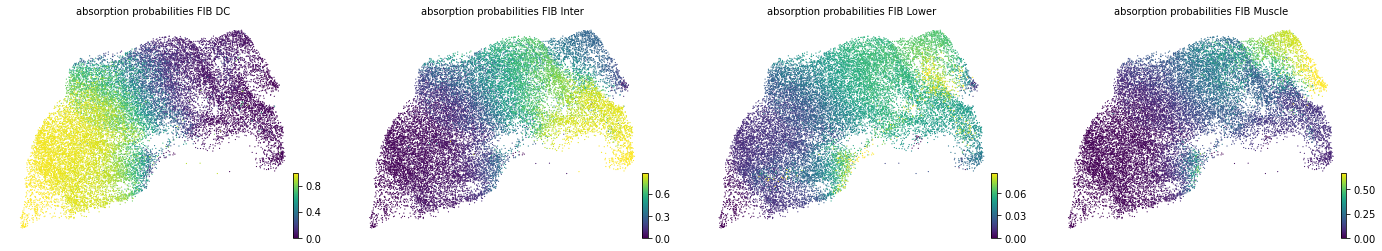

In [27]:
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99])

[<AxesSubplot:>]
[<AxesSubplot:>]
[<AxesSubplot:>]
[<AxesSubplot:>]


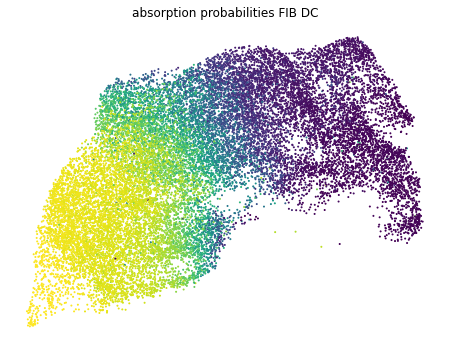

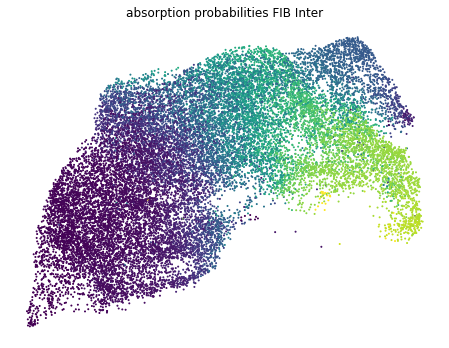

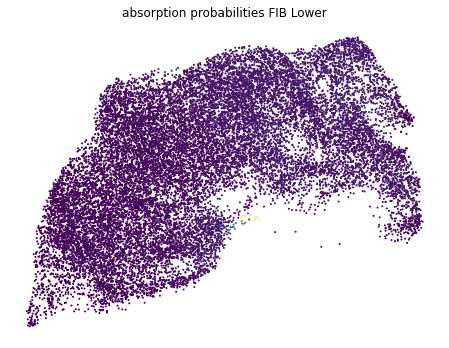

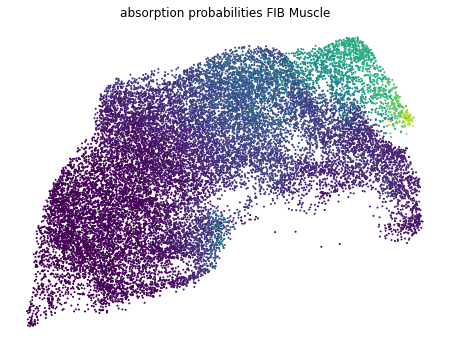

In [28]:
#Plot absorption probabilities individually for each terminal state - shared scale (max=1 for each plot)

perc = [0, 100] #percentile for colorbar min and max values
cmap = 'viridis'
abs_df = pd.DataFrame(data = g.absorption_probabilities, columns = g.absorption_probabilities.names, index = g.adata.obs_names)
mult = 3
x, y = zip(*adata_velo_nodeep.obsm['X_umap'])

for ix, col in enumerate(abs_df):
    ncols = 1
    fig, ax = plt.subplots(ncols = ncols, figsize = (2.6*ncols*mult, 1.95*mult))
    c = abs_df[col]
    vmin, vmax = np.percentile(c, perc)
    ax.scatter(x, y, c = c, cmap = cmap, vmin = vmin, vmax = vmax, s = 1)
    clean_axis(ax)
    ax.set_title(f'absorption probabilities {col}')
    fig.savefig(os.path.join(path, 'Notebook-Output', f'Fib_Origin-Absorption-SharedColors_{"_".join(col.split(" "))}.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

[<AxesSubplot:>]
[<AxesSubplot:>]
[<AxesSubplot:>]
[<AxesSubplot:>]


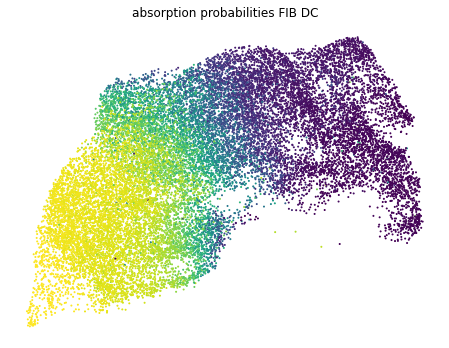

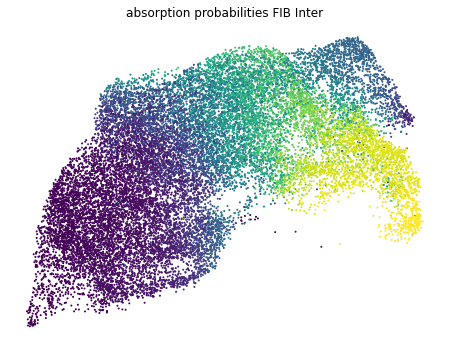

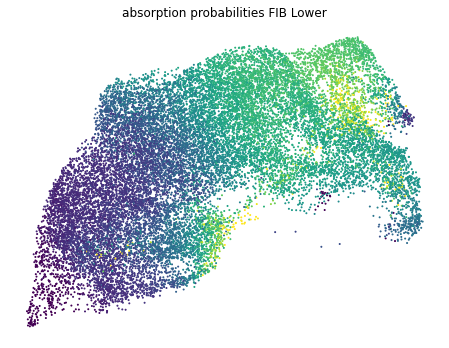

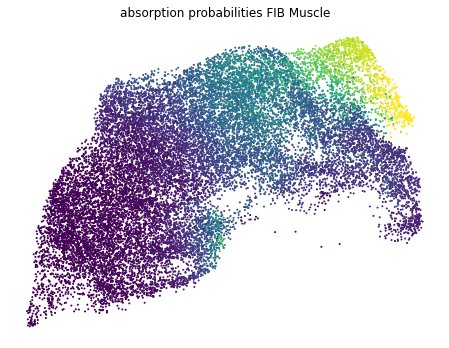

In [29]:
#Plot absorption probabilities individually for each terminal state - use own color scale for each plot (individual max values)

perc = [0, 99] #percentile for colorbar min and max values
cmap = 'viridis'
abs_df = pd.DataFrame(data = g.absorption_probabilities, columns = g.absorption_probabilities.names, index = g.adata.obs_names)
mult = 3
x, y = zip(*adata_velo_nodeep.obsm['X_umap'])
cbar_range = {}

for ix, col in enumerate(abs_df):
    ncols = 1
    fig, ax = plt.subplots(ncols = ncols, figsize = (2.6*ncols*mult, 1.95*mult))
    c = abs_df[col]
    vmin, vmax = np.percentile(c, perc)
    cbar_range[col] = np.percentile(c, perc)
    ax.scatter(x, y, c = c, cmap = cmap, vmin = vmin, vmax = vmax, s = 1)
    clean_axis(ax)
    ax.set_title(f'absorption probabilities {col}')
    fig.savefig(os.path.join(path, 'Notebook-Output', f'Fib_Origin-Absorption-IndividualColors_{"_".join(col.split(" "))}.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

/tmp/ipykernel_9325/2055451797.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticklabels()])


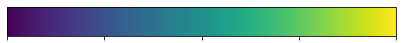

In [30]:
#Save colorbar with and without tick labels
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', cmap=mpl.cm.get_cmap('viridis'))
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
fig.savefig(os.path.join(path, 'Notebook-Output', f'Viridis_colorbar_TickLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)
ax.set_xticklabels(['' for x in ax.get_xticklabels()])
fig.savefig(os.path.join(path, 'Notebook-Output', f'Viridis_colorbar_NO-TickLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

## Retrieve absorption probabilites, quantify and plot

In [31]:
#Define origin clusters
origin_clusters = set([x for x in adata_velo_nodeep.obs['leiden_combined'] if 'Origin' in x])

#Get absorptsion probabilities and put into dataframe
abs_df = g.absorption_probabilities
abs_df = pd.DataFrame(abs_df, columns = abs_df.names, index = adata_velo_nodeep.obs_names)
abs_df['leiden_combined'] = adata_velo_nodeep.obs['leiden_combined'] #Include cluster information

abs_df = abs_df[abs_df['leiden_combined'].isin(origin_clusters)] #Keep only cells starting from origin
abs_df = abs_df.groupby('leiden_combined').mean().dropna() #Group accordingly and take mean probabilities for the origin cells
abs_df = abs_df.div(abs_df.sum(axis = 1), axis = 0) #Rescale the values to be between 0-1 (previous row sums were ~0.99998)
abs_df

FIB DC  FIB Inter  FIB Lower  FIB Muscle
leiden_combined                                            
FIB Origin1      0.748363   0.153375   0.025778    0.072483
FIB Origin2      0.669189   0.207091   0.029233    0.094487
FIB Origin3      0.474009   0.347444   0.038455    0.140093
FIB Origin4      0.317094   0.410326   0.049402    0.223178
FIB Origin5      0.215581   0.533492   0.053012    0.197915
FIB Origin6      0.079888   0.627011   0.055745    0.237356

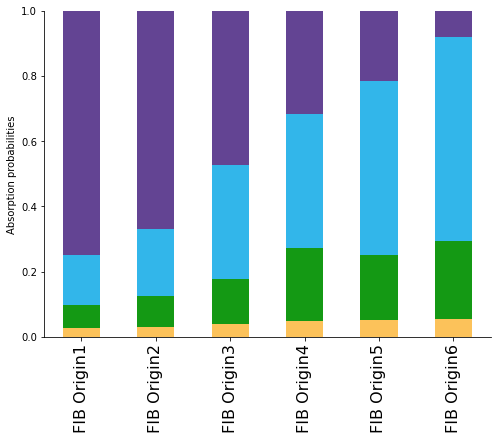

In [32]:
#Plot bar plot showcasing how likely a cell of the respective FIB origin subclusters ends up being absorbed into one of the four defined terminal end states (based on absorption probabilities)
cmap = {'FIB DC': '#FCC25A',
        'FIB Inter': '#149914',
        'FIB Lower': '#32B6EA',
        'FIB Muscle': '#634493'}

mult=2
fig, ax = plt.subplots(figsize = (4*mult, 3*mult))
abs_df.loc[['FIB Origin1','FIB Origin2','FIB Origin3','FIB Origin4','FIB Origin5','FIB Origin6'],['FIB Lower', 'FIB Muscle', 'FIB Inter', 'FIB DC']].plot.bar(stacked = True,ax = ax, color = cmap.values())
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 16, rotation = 90)  #Comment out if no labels are desired
ax.set_ylabel('Absorption probabilities')    #Comment out if no labels are desired
#ax.set_xticklabels([])    #Activate if no labels are desired
#ax.set_yticklabels([])    #Activate if no labels are desired
clear_output()
fig.savefig(os.path.join(path, 'Notebook-Output', 'Fib_Origin-Absorption-Quantification_WithLabels.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

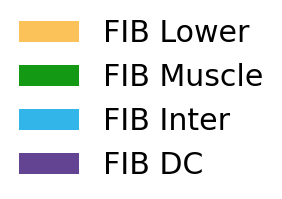

In [33]:
label_params = ax.get_legend_handles_labels()
figl, axl = plt.subplots(figsize = (2, 2))
axl.axis(False)
axl.legend(*label_params, loc="center", prop={"size":30},frameon=False,ncol=1,markerscale=2)
figl.savefig(os.path.join(path, 'Notebook-Output', 'Fib_Origin-Absorption_Legend.png'), transparent = True, bbox_inches = 'tight', dpi = 100)

# PAGA; Figure S2

In [34]:
#Calculate abstracted PAGA graph by quantifying the connectivity of fibroblast subclusters 
scv.tl.paga(
    adata_velo_nodeep,
    groups="leiden_named",
    root_key="initial_states_probs",
    use_time_prior="velocity_pseudotime",
)

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


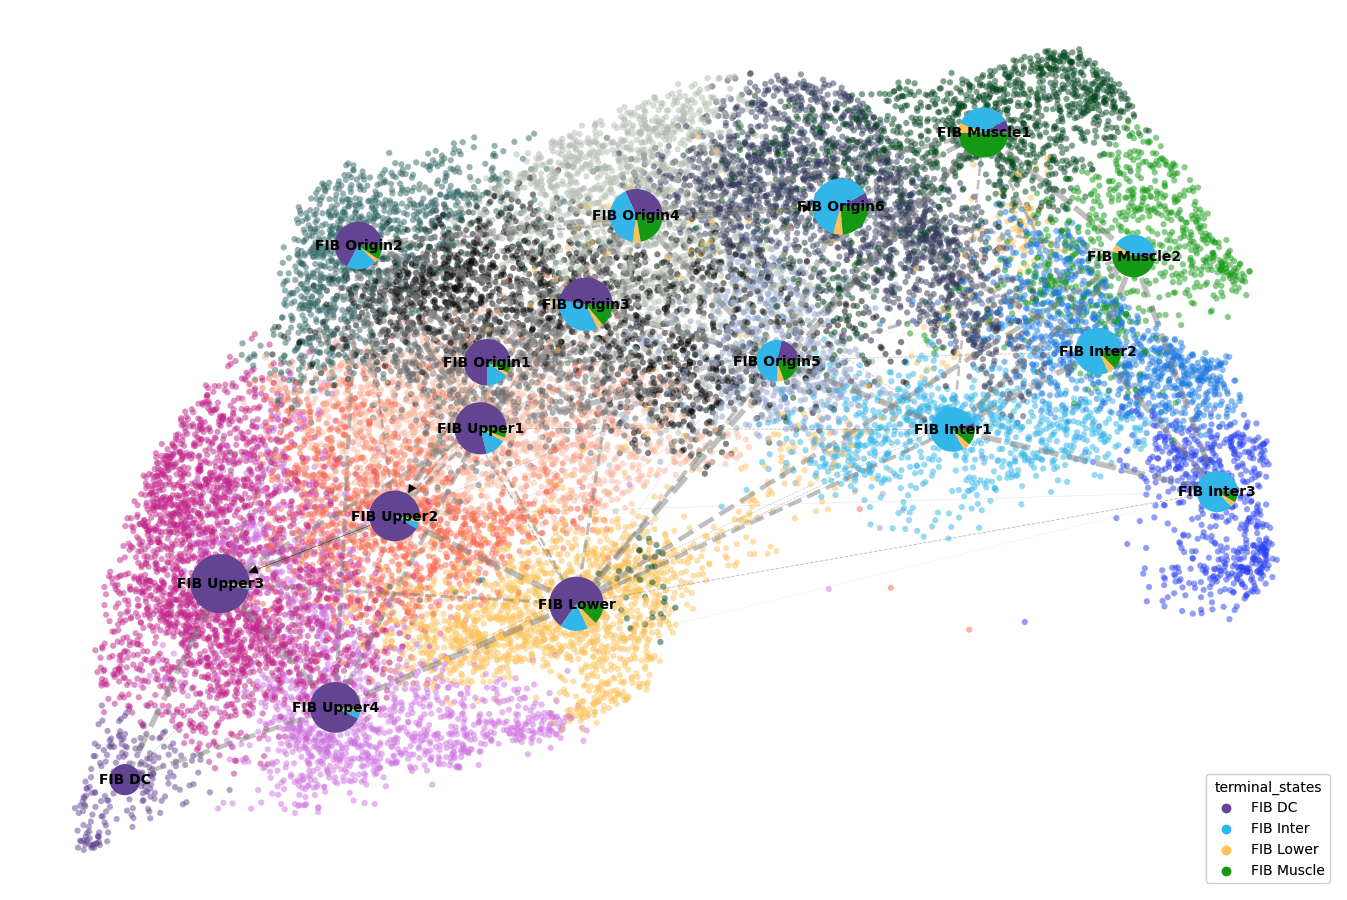

In [35]:
cr.pl.cluster_fates(
    adata_velo_nodeep,
    mode="paga_pie",
    cluster_key="leiden_named",
    basis="umap",
    legend_kwargs={"loc": "bottom right"},
    legend_loc="on data",
    node_size_scale=10,
    edge_width_scale=1,
    max_edge_width=4,
    title="",
    size = 80,
    figsize = (7*ncols*mult, 4.7*mult),
    dpi = 100,
    save = os.path.join(path, 'Notebook-Output', f'Fib_Origin-Absorption-PAGA.png')
)

## Save adata object as h5ad file

In [36]:
#h5ad file is provided on Zenodo
adata_velo_nodeep.write_h5ad(os.path.join(path, 'Notebook-Output', 'Adata-object_{}-FIB-origin-analysis.h5'.format(cell_type)))